# Figures 

## Libraries

In [1]:
import sys
sys.path.insert(0, 'src')

from powerlawdata.solver import silverstein_density, end_pts
from powerlawdata.datasets import load_cifar10, load_mnist, get_dataset

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
import torch
from IPython.display import display, Latex

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Functions

power law population density generation

In [2]:
def gen_lambda(M, alpha):
    return torch.diag(torch.tensor([ float(k**(-alpha)) for k in range(1, M+1)], device = device))

fractional difference plotting

In [24]:
def frac_excess(eigs, bins: np.ndarray, alpha: float, q: float, Lc: float):


    hist, bin_edges = np.histogram(eigs, bins, density=True)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    evals = bin_midpoints[::-1]
    num_density = silverstein_density(evals, alpha = alpha, q = q, Lc = Lc)
    rho_dict = {}
    for z, rho in zip(evals, num_density):
        rho_dict[z] = (q if q > 1 else 1)*abs(rho)
    zL, zR = end_pts(rho_dict)

    rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z in enumerate(bin_midpoints) if zR >= z >= zL and rho_dict[z] is not None]

    return rho_excess_tuples

    


## Marcenko-Pastur

In [3]:
def rho_mp_an(lm, lp, z):
    return np.sqrt((lp-z)*(z-lm))/(2*np.pi)/q/z

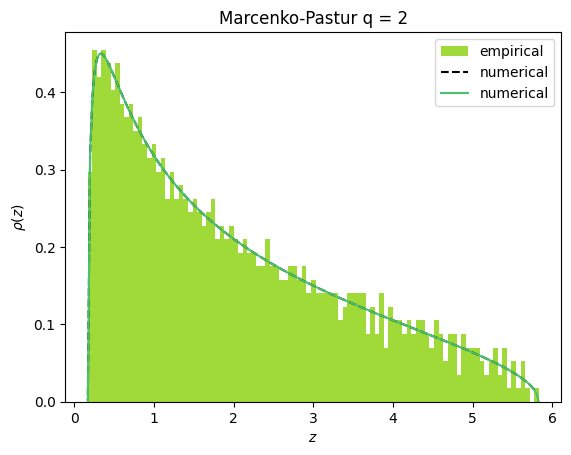

In [4]:
#parameters
q = 2
alpha = 1e-5
lm ,lp = (1-np.sqrt(q))**2, (1+np.sqrt(q))**2
evals  = np.linspace(lp, lm, 200)

#numerical and analytical densities
num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = 1-alpha)
an_density = [rho_mp_an(lm, lp, z) for z in evals]

#empirical
M = 2000
T = int(M/q)

dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M, device = device), gen_lambda(M, alpha))


PSI = dist.sample((T, ))
cov = PSI.T @ PSI /PSI.shape[0]
eigs = sorted(torch.linalg.eigvalsh(cov))[::-1]

sns.set_palette("viridis_r")


plt.hist(eigs, bins = np.linspace(lm, lp, 100), density = True, label = "empirical")
plt.plot(evals, [q*rho for rho in num_density], 'k--', label = "numerical")
plt.plot(evals, [q*rho for rho in an_density], label = "numerical")
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title("Marcenko-Pastur q = 2")
plt.legend()
plt.show()
#plt.vlines([zL, zR], ymin = 1e-5, ymax = 5e3, linestyle="--", color="tab:green")

/var/folders/5z/pb__6h252xz54rgpylnspyw00000gn/T/ipykernel_95441/2393777015.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z in enumerate(bin_midpoints) if zR >= z >= zL and rho_dict[z] is not None]


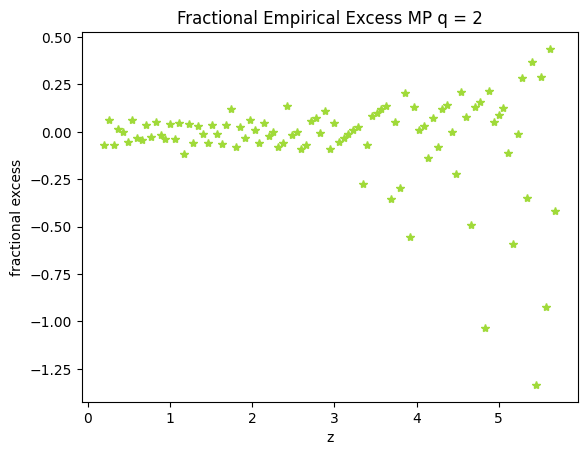

In [34]:
excess_tuples = frac_excess(eigs, bins = np.linspace(lm, lp, 100), alpha = alpha, q = q, Lc = 1-alpha)
excess_tuples = np.array(excess_tuples)
plt.plot(excess_tuples[:, 0], excess_tuples[:, 1], "*")
plt.xlabel("z")
plt.ylabel("fractional excess")
plt.title("Fractional Empirical Excess MP q = 2")
plt.show()

## Powerlaw 

In [ ]:

#parameters
M = 1000
q = 2
alpha = 1.5
evals = np.logspace(1, -6, 250)

#numerical density
num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = M**-alpha)
rho_dict = {}
for z, rho in zip(evals, num_density):
    rho_dict[z] = abs(rho)
zL, zR = end_pts(rho_dict)


#empirical
T = int(M/q)

dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M, device = device), gen_lambda(M, alpha))


PSI = dist.sample((T, ))
cov = PSI.T @ PSI /PSI.shape[0]
eigs = sorted(torch.linalg.eigvalsh(cov))[::-1]

/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_re, _ = quad(int_re, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_im, _ = quad(int_im, np.log(Lc), 0)


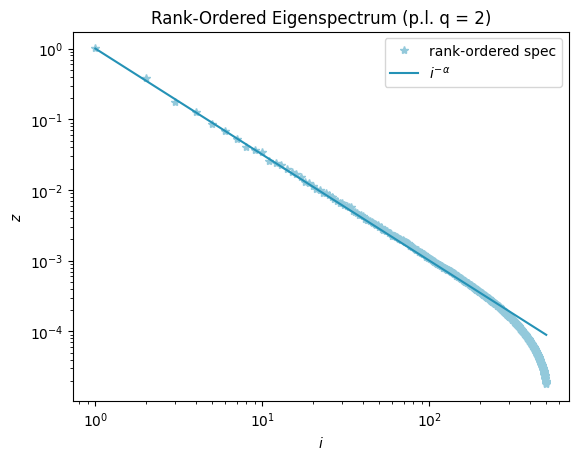

In [47]:
sns.set_palette("ocean_r")

max_idx = len(eigs) if q < 1 else len(eigs)//q
ranked_eigs = sorted(eigs)[::-1][:max_idx]
idxs= np.arange(1, 1+len(ranked_eigs))

plt.loglog(idxs, ranked_eigs, "*", label="rank-ordered spec")
plt.loglog(idxs, [i**(-alpha) for i in idxs], label = r"$i^{-\alpha}$")
plt.xlabel(r"$i$")
plt.ylabel(r"$z$")
plt.title("Rank-Ordered Eigenspectrum (p.l. q = 2)")
plt.legend()
plt.show()

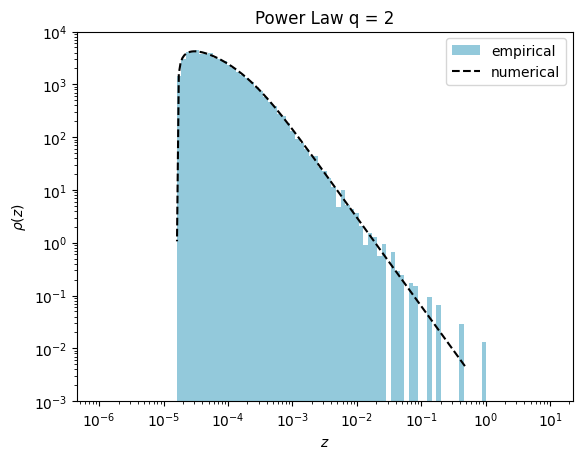

In [37]:
sns.set_palette("ocean_r")


plt.hist(eigs, np.logspace(-6, 1, 100), density = True, label = "empirical")
plt.plot([z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [q*rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], 'k--', label = "numerical")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1e4)
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title("Power Law q = 2")
plt.legend()
plt.show()

/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/var/folders/5z/pb__6h252xz54rgpylnspyw00000gn/T/ipykernel_95441/2393777015.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z in enumerate(bin_midpoints) if zR >= z >= zL and rho_dict[z] is not None]


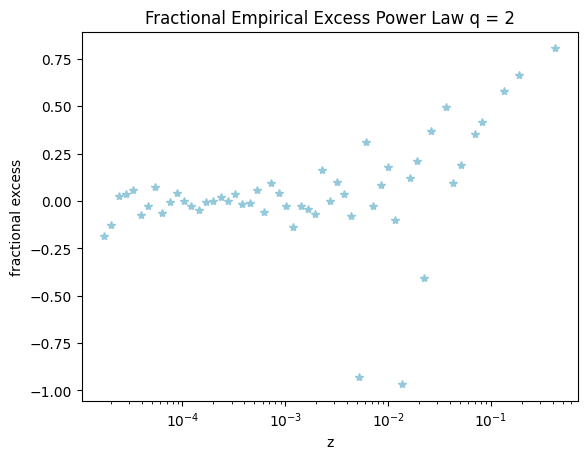

In [40]:
excess_tuples = frac_excess(eigs, np.logspace(-6, 1, 100), alpha = alpha, q = q, Lc = M**-alpha)
excess_tuples = np.array(excess_tuples)
plt.plot(excess_tuples[:, 0], excess_tuples[:, 1], "*")
plt.xscale('log')
plt.xlabel("z")
plt.ylabel("fractional excess")
plt.title("Fractional Empirical Excess Power Law q = 2")
plt.show()

### Near Equiparameterized

In [ ]:
alpha = 1.7
q = .99
dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M, device = device), gen_lambda(M, alpha))
T = int(M/q)
PSI = dist.sample((T, ))
cov = PSI.T @ PSI /T
eigs = sorted(torch.linalg.eigvalsh(cov))[::-1]


evals = np.logspace(-12, 0.5, 600)[::-1]
Lc = M**-alpha
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))



In [51]:
#numerical and analytical densities
num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = M**-alpha)
rho_dict = {}
for z, rho in zip(evals, num_density):
    rho_dict[z] = abs(rho)
zL, zR = end_pts(rho_dict)


/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_re, _ = quad(int_re, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  diff_re, _ = quad(int_re, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It

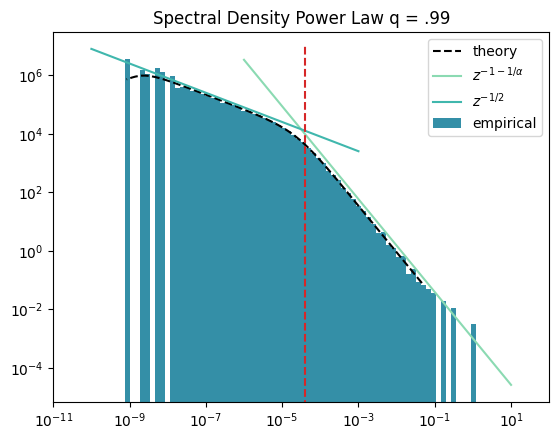

In [55]:
sns.set_palette("mako_r")


plt.loglog([z for z in rho_dict.keys() if zR >= z >= zL and rho_dict[z] is not None], [rho_dict[z] for z in rho_dict.keys() if zR >= z >= zL and rho_dict[z] is not None], "k--", label= "theory")
plt.loglog([z for z in np.logspace(-6, 1, 20)], [1e-3*z**-(1+1/alpha) for z in np.logspace(-6, 1, 20)], label=r"$z^{-1-1/\alpha}$")
plt.loglog([z for z in np.logspace(-10, -3, 20)], [8e1*z**-(.5) for z in np.logspace(-10, -3, 20)], label=r"$z^{-1/2}$")
plt.vlines(4e-5, 1e-9, 1e7, colors="tab:red", linestyles="dashed")
plt.hist(eigs, bins =np.logspace(-12, 1, 100), density=True, label="empirical")
plt.xlim(1e-11, 1e2)
plt.xscale("log")
plt.yscale("log")
plt.title("Spectral Density Power Law q = .99")
plt.legend()
plt.show()

/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_re, _ = quad(int_re, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/var/folders/5z/pb__6h252xz54rgpylnspyw00000gn/T/ipykernel_95441/2393777015.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z i

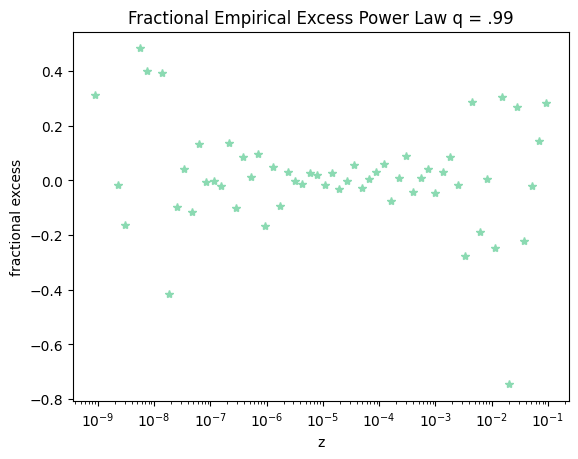

In [56]:
excess_tuples = frac_excess(eigs, bins =np.logspace(-12, 1, 100), alpha = alpha, q = q, Lc = M**-alpha)
excess_tuples = np.array(excess_tuples)
plt.plot(excess_tuples[:, 0], excess_tuples[:, 1], "*")
plt.xscale('log')
plt.xlabel("z")
plt.ylabel("fractional excess")
plt.title("Fractional Empirical Excess Power Law q = .99")
plt.show()